In [ ]:
import json
import os
import csv
import math
import ast 
import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
import xgboost as xgb
import matplotlib.image as mpimg
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression,Lasso,Ridge, RANSACRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from ultralytics import YOLO


path = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/data/events'
event_files = []
all_files = os.listdir(path)

for i in range (len(all_files)):
    nom = os.path.join(path, all_files[i])
    if os.path.isfile(nom):
        event_files.append(nom)


output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'

goal_center = [120, 40]
fields = [
    'event_id', 'period', 'minute',  
    'team', 'player', 'location', 'shot_distance',
    'shot_angle', 'body_part', 'play_pattern', 'freeze_frame', 
    'technique', 'statsbomb_xg', 'type', 'aerial_won', 'open_goal'
]

with open(output_csv, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fields)
    writer.writeheader()

    for file_path in event_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            events = json.load(f)
            
            match_id = os.path.basename(file_path).replace('.json', '')
            
            for event in events:
                if event.get('type', {}).get('name') == 'Shot':
                    location = event.get('location')
                    aerial_won=event.get('shot', {}).get('aerial_won')
                    open_goal= event.get('shot',{}).get('open_goal')
                    freeze_frame=event.get('shot', {}).get('freeze_frame')
                    if location:

                        shot_distance = math.sqrt((goal_center[0] - location[0]) ** 2 + (goal_center[1] - location[1]) ** 2)
                        adj_side = abs(goal_center[0] - location[0])
                        
                        if shot_distance != 0:
                            shot_angle = math.degrees(math.acos(adj_side / shot_distance))
                        else:
                            shot_angle = None
                    else:
                        shot_distance = None
                        shot_angle = None
                    if aerial_won:
                        aerial_won=1
                    else:
                        aerial_won=0
                    if open_goal:
                        open_goal=1
                    else:
                        open_goal=0 
                    if (freeze_frame is None)or (type(freeze_frame)==list and len(freeze_frame)==0):
                        freeze_frame=0
                    else:
                        freeze_frame=freeze_frame

                    shot_data = {
                        'event_id': event.get('id'),
                        'period': event.get('period'),
                        'minute': event.get('minute'),
                        'team': event.get('team', {}).get('name'),
                        'player': event.get('player', {}).get('name'),
                        'location': location,
                        'shot_distance': shot_distance,
                        'shot_angle': shot_angle,
                        'body_part':event.get('shot', {}).get('body_part', {}).get('name'),
                        'play_pattern': event.get('play_pattern', {}).get('name'),
                        'freeze_frame': freeze_frame,
                        'technique': event.get('shot', {}).get('technique', {}).get('name'),
                        'statsbomb_xg': event.get('shot', {}).get('statsbomb_xg'),
                        'type': event.get('shot', {}).get('type', {}).get('name'),
                        'aerial_won': aerial_won,
                        'open_goal': open_goal
                    }
                    
                    writer.writerow(shot_data)

print(f"Dades de remats guardades a {output_csv}")

Dades de remats guardades a C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv


In [ ]:
output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'
df = pd.read_csv(output_csv)
df2 = pd.read_csv(output_csv)

### **1.ADA I PREPROCESSING**

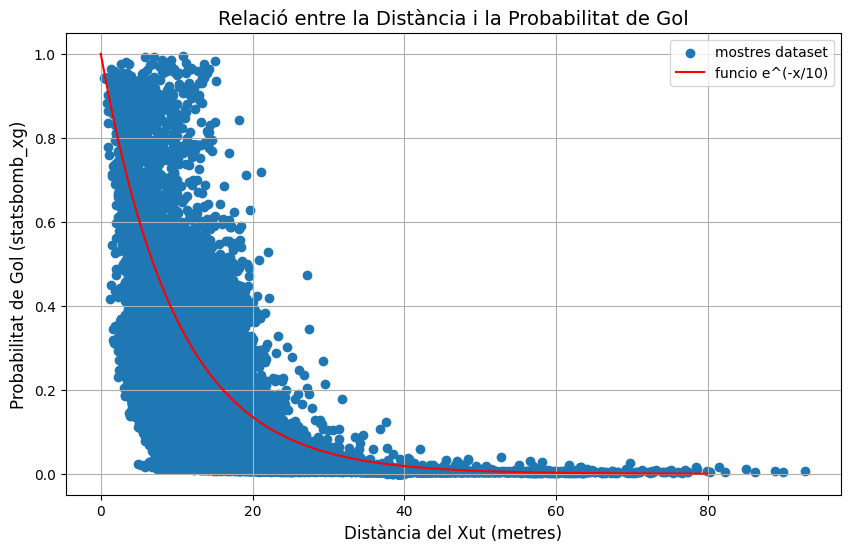

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(df['shot_distance'], df['statsbomb_xg'], label="mostres dataset")
x=np.arange(0,80,0.1)
plt.plot(x,np.exp(-x/10), color="red", label="funcio e^(-x/10)")
plt.title('Relació entre la Distància i la Probabilitat de Gol', fontsize=14)
plt.xlabel('Distància del Xut (metres)', fontsize=12)
plt.ylabel('Probabilitat de Gol (statsbomb_xg)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

En aquest gràfic s'escenifica clarament la relació exponencial inversa que hi ha entre la distància i la probabilitat de gol calculada per statsbomb_xg.

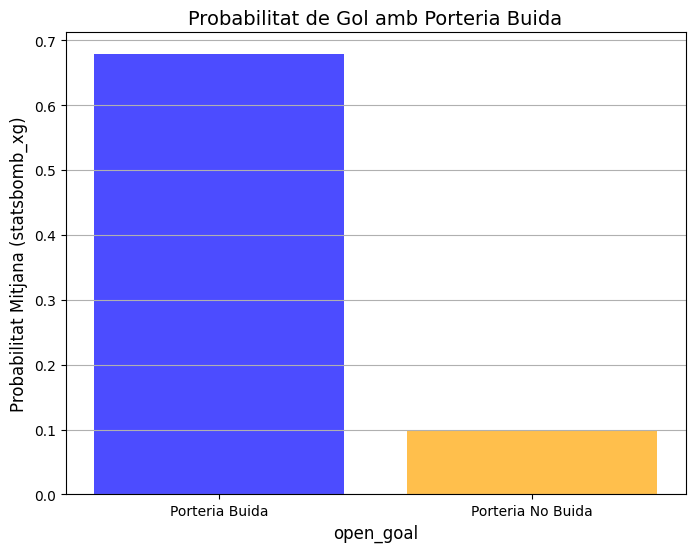

In [ ]:

open_goal_mean = df[df['open_goal'] == True]['statsbomb_xg'].mean()
not_open_goal_mean = df[df['open_goal'] == False]['statsbomb_xg'].mean()

categories = ['Porteria Buida', 'Porteria No Buida']
values = [open_goal_mean, not_open_goal_mean]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['blue', 'orange'], alpha=0.7)
plt.title('Probabilitat de Gol amb Porteria Buida', fontsize=14)
plt.ylabel('Probabilitat Mitjana (statsbomb_xg)', fontsize=12)
plt.xlabel('open_goal', fontsize=12)
plt.grid(axis='y')
plt.show()

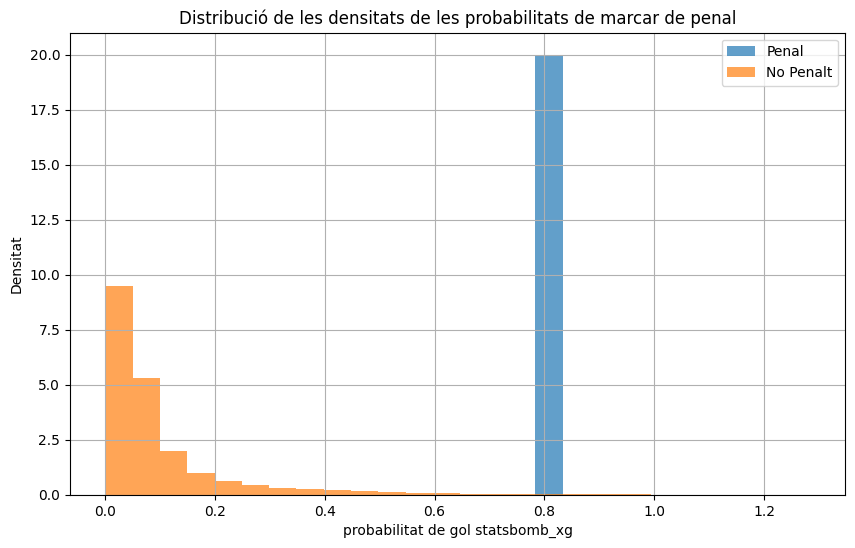

In [6]:
penalty_data = df[df['type'] == 'Penalty']
non_penalty_data = df[df['type'] != 'Penalty']

plt.figure(figsize=(10, 6))
plt.hist(penalty_data['statsbomb_xg'], bins=20, alpha=0.7, label='Penal', density=True)
plt.hist(non_penalty_data['statsbomb_xg'], bins=20, alpha=0.7, label='No Penalt', density=True)
plt.title('Distribució de les densitats de les probabilitats de marcar de penal')
plt.xlabel('probabilitat de gol statsbomb_xg')
plt.ylabel('Densitat')
plt.legend()
plt.grid()
plt.show()

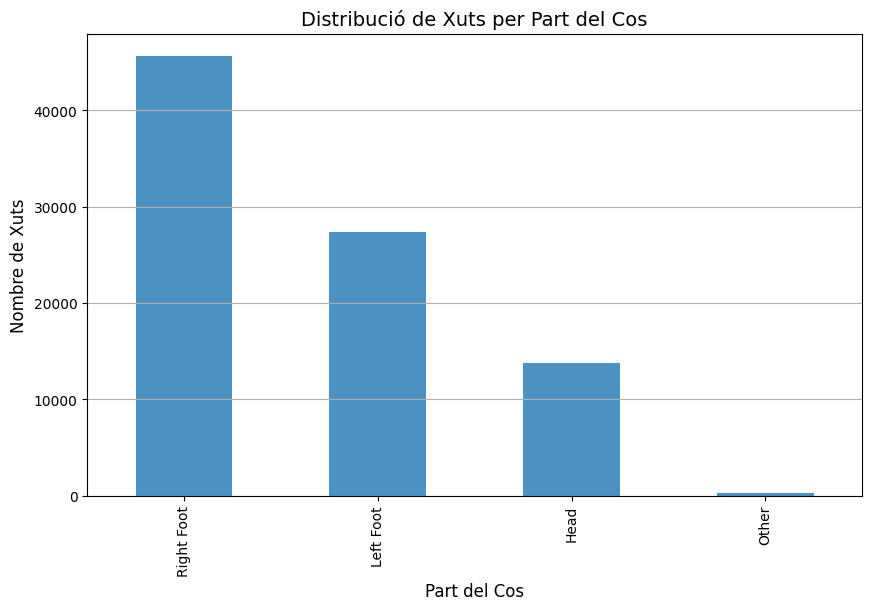

In [7]:
plt.figure(figsize=(10, 6))
df['body_part'].value_counts().plot(kind='bar', alpha=0.8)
plt.title('Distribució de Xuts per Part del Cos', fontsize=14)
plt.xlabel('Part del Cos', fontsize=12)
plt.ylabel('Nombre de Xuts', fontsize=12)
plt.grid(axis='y')
plt.show()

Tot seguit convertim la característica freeze_frame a una llista de diccionaris perquè al recopilar-lo des dels arxius .json es transmet en forma de cadena.

In [ ]:

def convert_freeze_frame(value):
    try:
        if value == "0":  
            return []
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

df['freeze_frame'] = df['freeze_frame'].apply(convert_freeze_frame)
df2['freeze_frame'] = df2['freeze_frame'].apply(convert_freeze_frame)

A continuació definirem les dimensions del nostre terreny de joc i visualitzarem les dades d'una forma més representativa

In [ ]:

def draw_field(ax):

    field_length = 120
    field_width = 80

    # Dibujar el contorno del campo
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([60, 60], [0, field_width], color="black")

    # Dibujar las áreas de penalti
    ax.plot([0, 18, 18, 0], [18, 18, 62, 62], color="black")  # Área izquierda
    ax.plot([120, 102, 102, 120], [18, 18, 62, 62], color="black")  # Área derecha

    # Dibujar las áreas pequeñas
    ax.plot([0, 6, 6, 0], [30, 30, 50, 50], color="black")  # Área pequeña izquierda
    ax.plot([120, 114, 114, 120], [30, 30, 50, 50], color="black")  # Área pequeña derecha

    # Dibujar los círculos centrales y los puntos de penalti
    center_circle = patches.Circle((60, 40), 10, color="black", fill=False)  # Círculo central
    ax.add_patch(center_circle)
    ax.plot(60, 40, 'o', color="black")  # Centro del campo
    ax.plot(11, 40, 'o', color="black")  # Punto penal izquierdo
    ax.plot(109, 40, 'o', color="black")  # Punto penal derecho

    # Dibujar los arcos de las áreas de penalti
    left_arc = patches.Arc((18, 40), 10, 15, theta1=-90, theta2=90, color="black")
    right_arc = patches.Arc((102, 40), 10,15, theta1=90, theta2=270, color="black")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Dibujar los arcos de las porterías
    ax.plot([0, 0], [36, 44], color="black")  # Portería izquierda
    ax.plot([120, 120], [36, 44], color="black")  # Portería derecha

    # Configurar los límites del gráfico
    ax.set_xlim(-5, field_length + 5)
    ax.set_ylim(-5, field_width + 5)
    ax.set_aspect("equal")

    # Invertir el eje Y para que Y=0 esté en la parte superior
    ax.invert_yaxis()



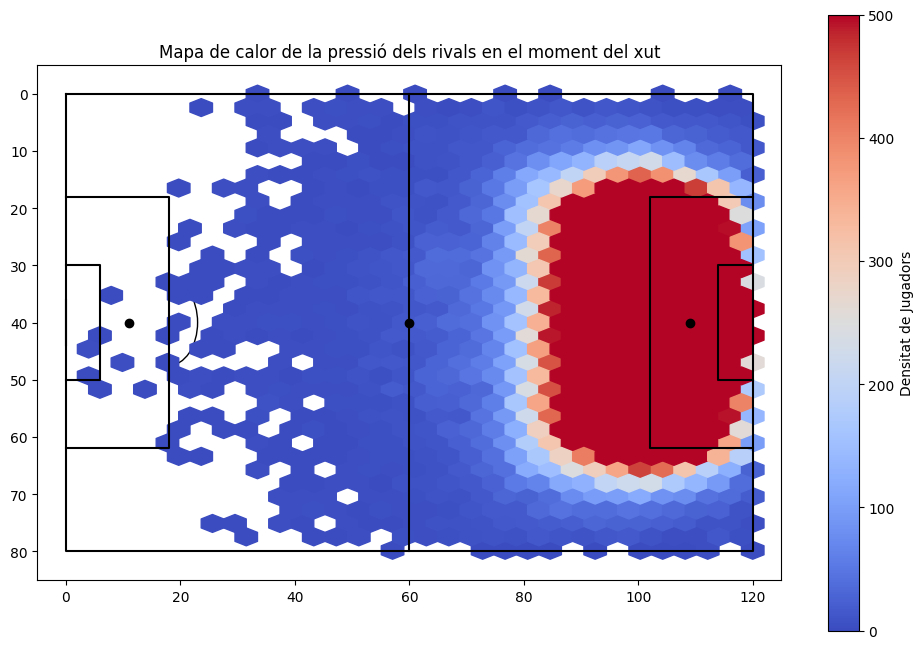

In [10]:
# Coordenadas de los jugadores
x = []
y = []
for i in range(len(df)):
    element = df['freeze_frame'][i]
    for jugador in [j for j in element if j['teammate'] == False]:
        if jugador['location'][0] is not None and jugador['location'][1] is not None:
            x.append(jugador['location'][0])
            y.append(jugador['location'][1])


fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1, vmin=0, vmax=500)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densitat de Jugadors')


ax.set_title("Mapa de calor de la pressió dels rivals en el moment del xut")
plt.show()


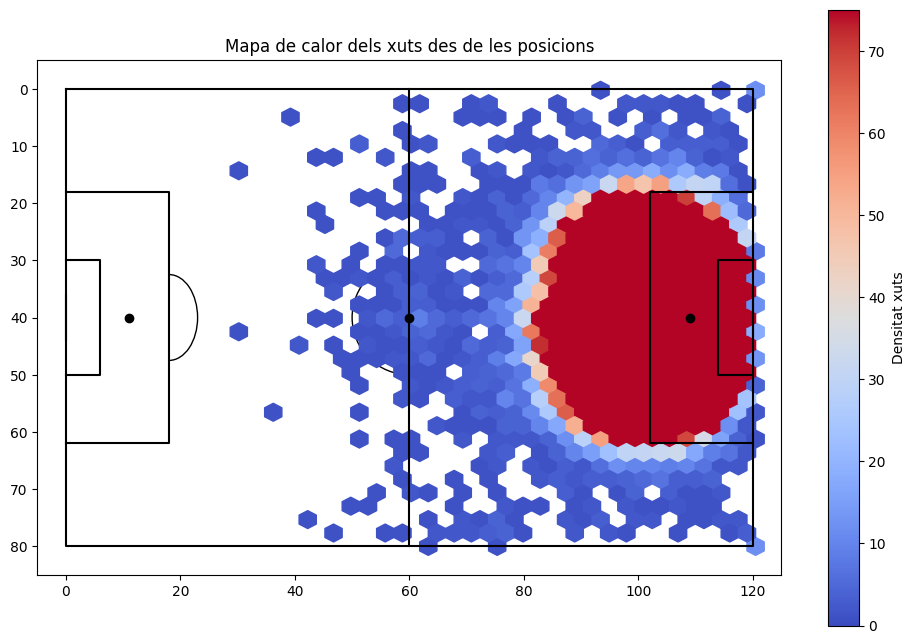

In [11]:
x=[]
y=[]
for i in range(len(df)):
    posicio_rematador=ast.literal_eval(df['location'][i])
    x.append(posicio_rematador[0])
    y.append(posicio_rematador[1])
fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1,vmin=0, vmax=75)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densitat xuts')


ax.set_title("Mapa de calor dels xuts des de les posicions")
plt.show()

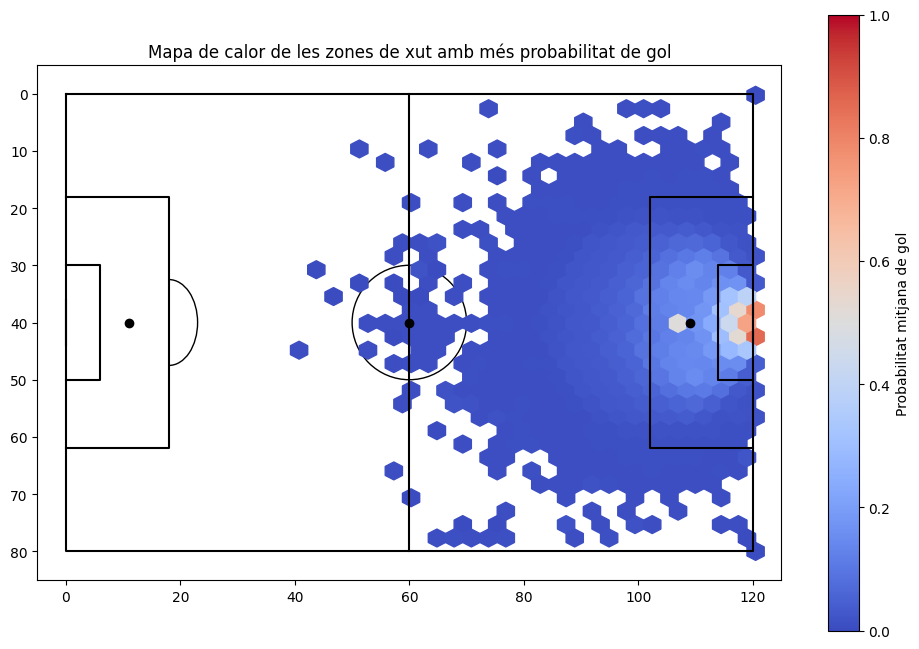

In [12]:
x = []
y = []
probabilitats = []

for i in range(len(df)):
    posicio_rematador = ast.literal_eval(df['location'][i])
    x.append(posicio_rematador[0])
    y.append(posicio_rematador[1])
    probabilitats.append(df['statsbomb_xg'][i])  

fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(
    x, y, C=probabilitats, gridsize=30, cmap='coolwarm',
    reduce_C_function=np.mean, mincnt=1, vmin=0, vmax=1
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Probabilitat mitjana de gol')

ax.set_title("Mapa de calor de les zones de xut amb més probabilitat de gol")
plt.show()


In [13]:
def calcular_distancia(punt1, punt2):
    return math.sqrt((punt2[0] - punt1[0]) ** 2 + (punt2[1] - punt1[1]) ** 2)


def calcular_angle(origen, punt1, punt2):
    if(origen!=None and punt1!=None and punt2!=None):
        vector1 = (origen[0]-punt1[0], origen[1]-punt1[1])
        vector2 = (origen[0]-punt2[0], origen[1]-punt2[1])
        producto_escalar = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        magnitud1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)
        magnitud2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)
        if magnitud1 == 0 or magnitud2 == 0:
            return None
        cos_angulo = producto_escalar / (magnitud1 * magnitud2)
        angulo = math.acos(max(min(cos_angulo, 1), -1))  
        return math.degrees(angulo)
    else:
        return 0

A continuació, ens hem adonat que la característica freeze_frame és molt carregosa, ja que conté diverses informacions sobre cadascun dels rivals en el moment del xut. Com que inclou molta informació irrellevant, per reduir la dimensionalitat del dataset hem ideat un coeficient que substitueix freeze_frame. Aquest coeficient considera la distància entre el punt de xut i cadascun dels jugadors rivals de manera regulada. Es calcula de forma exponencial, de manera que les distàncies grans tenen molt menys pes. A més, hem decidit incorporar-hi una constant arbitrària d0, que regula els valors de la funció. Aquesta constant es pot ajustar posteriorment, tractant-la com un hiperparàmetre del model.
La funció en qüestió que hem dissenyat per modelitzar la pressió és:
$\sum_{i=1}^{11} \frac{e^{-\frac{d_i}{d_0}}}{11}$

On:
-  $d_i$ és la distància del rival $i$ al rematador.
- $d_0$ és un paràmetre de referència utilitzat per regular la funció.

D'aquesta manera, en el cas hipotètic de que la pressió fos màxima (si el rematador pogués tenir els 11 jugadors a 0 metres de distància) el coeficient seria 1. En el cas contrari (si els jugadors rivals poguessin estar a una distància infinita del rematador) seria 0.


In [14]:
d0=100
def calcul_coeficient_Tubert_Mercader(d0):
    llista_coeficients = []
    for idx, row in df2.iterrows():  
        coeficient_Tubert_Mercader = 0
        punt_xutador = ast.literal_eval(row['location'])  
        freeze_frame = row['freeze_frame']
        
        for jugador in freeze_frame:  
            if not jugador.get('teammate', True):
                punt_rival = jugador['location']
                if (punt_rival[0]+2>punt_xutador[0] or calcular_distancia(punt_xutador,punt_rival)<2): 
                    dist = calcular_distancia(punt_xutador, punt_rival)
                    coeficient_Tubert_Mercader += math.exp(-dist/d0) 
        llista_coeficients.append(coeficient_Tubert_Mercader/11)
    
    df2['freeze_frame'] = llista_coeficients
    df2.rename(columns={'freeze_frame': 'coeficientTM'}, inplace=True)
    return [llista_coeficients]

calcul_coeficient_Tubert_Mercader(d0)
print(df2.head())


                               event_id  period  minute              team  \
0  becd7956-ce44-479e-8fc9-16a2d1f1f349       1       2         Barcelona   
1  9107d374-2942-4876-a14f-1b9f86901c15       1       5         Barcelona   
2  ddd194ca-08fb-43d0-87c2-33647f975f9f       1      15         Barcelona   
3  86596ddb-d824-4e5e-b18c-b4442e9ce7cf       1      16  Deportivo Alavés   
4  3ed2b107-be17-42d5-9d1b-25006a0e55cb       1      18         Barcelona   

                           player       location  shot_distance  shot_angle  \
0  Lionel Andrés Messi Cuccittini  [111.5, 52.9]      15.448625   56.618524   
1                Jordi Alba Ramos  [113.9, 26.4]      14.905368   65.842363   
2  Lionel Andrés Messi Cuccittini   [93.7, 34.7]      26.828716   11.393698   
3           Rubén Sobrino Pozuelo  [109.2, 39.1]      10.837435    4.763642   
4        Luis Alberto Suárez Díaz  [107.8, 24.7]      19.568597   51.431645   

    body_part   play_pattern  coeficientTM    technique  stats

In [15]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for jugador in aux:
        if jugador['position']['name']=='Goalkeeper':
            posicio_porter= jugador['location']
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        df.at[i,'distancia jugador'+" "+str(idx)]=distancia
        df.at[i,'angle jugador'+" "+str(idx)]=angle_rematador_rival_porter
        
 

In [16]:
#TO DO:INSPECCIÓ NANS ANGLES:

In [17]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                    0
period                      0
minute                      0
team                        0
player                      0
location                    0
shot_distance               0
shot_angle                  0
body_part                   0
play_pattern                0
freeze_frame                0
technique                   0
statsbomb_xg                0
type                        0
aerial_won                  0
open_goal                   0
distancia jugador 0      1149
angle jugador 0         28076
distancia jugador 1      1318
angle jugador 1          7995
distancia jugador 2      1470
angle jugador 2          5694
distancia jugador 3      2231
angle jugador 3          6457
distancia jugador 4      4319
angle jugador 4          8935
distancia jugador 5      8143
angle jugador 5         13677
distancia jugador 6     14453
angle jugador 6         21291
distancia jugador 7     24976
angle jugador 7         32816
distancia jugador 8     40225
angle juga

Com podem veure, tot i que el nombre de nans entre "distancia jugador i" i "angle jugador i" hauria de coincidir, als angles tenen bastants mes Nans en comparació amb les distàncies, especialment en els primers registres. Anem a veure què pot estar passant prenent com mostra l'angle del jugador 0 (característica on es dona més el fenòmen i on hi ha una clara evidència de que no és casualitat)

In [18]:
llista=[j for j in range(len(df)) if pd.isnull(df['angle jugador 0'][j])]
inspeccio=[]
for i in llista:
    if (len(df['freeze_frame'][i])>0):
        inspeccio.append(df['freeze_frame'][i][0]['position']['name'])
        
unic = set(inspeccio)  
position_counts = {position:inspeccio.count(position) for position in unic}
ordenat=dict(sorted(position_counts.items(), key=lambda item: item[1], reverse=True))
for i,j in ordenat.items():
    print(i,":",j)
    

Goalkeeper : 17172
Center Forward : 1105
Right Wing : 982
Left Wing : 903
Right Back : 697
Left Back : 689
Center Attacking Midfield : 601
Left Center Midfield : 591
Right Center Midfield : 547
Right Midfield : 454
Right Center Forward : 447
Left Center Forward : 424
Right Defensive Midfield : 418
Left Midfield : 399
Left Defensive Midfield : 393
Right Center Back : 293
Left Center Back : 255
Center Defensive Midfield : 179
Left Wing Back : 156
Right Wing Back : 123
Left Attacking Midfield : 41
Right Attacking Midfield : 33
Center Back : 24
Center Midfield : 2
Secondary Striker : 1


Com podem comprovar la majoria dels valor Nans de l'angle del jugador 0 són en porters ja que la funció calcular_angle agafa com a origen la posició del porter, aleshores, com hem establert en la funció, l'angle que formarà el porter amb el rematador agafant la posició del guardameta com a origen serà None.
A continuació omplenarem aquests valors per l'angle que es forma entre el porter i el rematador respecte el centre de la porteria. En cas que el porter estigui exactament al centre de la porteria assignarem l'angle calculat al principi "shot_angle" que equival a l'angle format entre el rematador i el centre de la porteria (on està ara el porter).

In [19]:
#ASSIGNAR NANS

In [20]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_porter_porteria = calcular_angle(goal_center, posicio_rival, posicio_rematador)
        if jugador['position']['name']=='Goalkeeper'and posicio_rival!=goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= angle_rematador_porter_porteria
        elif jugador['position']['name']=='Goalkeeper'and posicio_rival==goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= df['shot_angle'][i]
df.to_csv(output_csv, index=False)

In [21]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                    0
period                      0
minute                      0
team                        0
player                      0
location                    0
shot_distance               0
shot_angle                  0
body_part                   0
play_pattern                0
freeze_frame                0
technique                   0
statsbomb_xg                0
type                        0
aerial_won                  0
open_goal                   0
distancia jugador 0      1149
angle jugador 0          1150
distancia jugador 1      1318
angle jugador 1          1319
distancia jugador 2      1470
angle jugador 2          1472
distancia jugador 3      2231
angle jugador 3          2232
distancia jugador 4      4319
angle jugador 4          4320
distancia jugador 5      8143
angle jugador 5          8144
distancia jugador 6     14453
angle jugador 6         14453
distancia jugador 7     24976
angle jugador 7         24977
distancia jugador 8     40225
angle juga

In [23]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        if(posicio_rival[0]<posicio_rematador[0] and distancia>=2):
            df.at[i,'distancia jugador'+" "+str(idx)]=0
            df.at[i,'angle jugador'+" "+str(idx)]=0

df.dropna(axis=1, thresh=len(df) * 0.5, inplace=True)  
df.fillna(0, inplace=True)

In [24]:
df.drop('freeze_frame', axis=1, inplace=True)


In [ ]:
print(df.describe())
print(df.head(10))
print(df.size)

             period        minute  shot_distance    shot_angle  statsbomb_xg  \
count  87111.000000  87111.000000   87111.000000  87111.000000  87111.000000   
mean       1.563499     49.070049      19.202526     27.655110      0.106297   
std        0.557955     27.207676       8.752675     18.811389      0.149382   
min        1.000000      0.000000       0.400000      0.000000      0.000180   
25%        1.000000     26.000000      12.010620     12.002295      0.027673   
50%        2.000000     49.000000      18.445596     25.540715      0.054790   
75%        2.000000     72.000000      25.525673     40.834941      0.110060   
max        5.000000    139.000000      92.800862     90.000000      0.995122   

         aerial_won     open_goal  distancia jugador 0  angle jugador 0  \
count  87111.000000  87111.000000         87111.000000     87111.000000   
mean       0.082963      0.010768             9.419037        17.960221   
std        0.275828      0.103209             9.839872

In [26]:
#NaNs columna 
missing_values = df.isnull().sum()
print(missing_values)
missing_percentages = (missing_values / len(df)) * 100

print("Percentatge de valors NaN per columna:\n", missing_percentages[missing_percentages > 0])

missing_values = missing_values[missing_values > 0]



event_id               0
period                 0
minute                 0
team                   0
player                 0
location               0
shot_distance          0
shot_angle             0
body_part              0
play_pattern           0
technique              0
statsbomb_xg           0
type                   0
aerial_won             0
open_goal              0
distancia jugador 0    0
angle jugador 0        0
distancia jugador 1    0
angle jugador 1        0
distancia jugador 2    0
angle jugador 2        0
distancia jugador 3    0
angle jugador 3        0
distancia jugador 4    0
angle jugador 4        0
distancia jugador 5    0
angle jugador 5        0
distancia jugador 6    0
angle jugador 6        0
distancia jugador 7    0
angle jugador 7        0
distancia jugador 8    0
angle jugador 8        0
dtype: int64
Percentatge de valors NaN per columna:
 Series([], dtype: float64)


In [27]:
#Com podem veure, el fet que alguns remats tinguéssin NaNs a freeze_frame es deu a que es tracta de penals (on el realitzador no té cap jugador que el pugui condicionar.)

In [ ]:

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
for i in [df,df2]:
    numeric_features = i.select_dtypes(include=np.number).keys()
    non_numeric = [col for col in i.columns if col not in numeric_features]
    label_encoders = {}
    for col in non_numeric:
        le = LabelEncoder()
        i[col] = le.fit_transform(i[col])
        label_encoders[col] = le
    print(i.dtypes)


event_id                 int32
period                   int64
minute                   int64
team                     int32
player                   int32
location                 int32
shot_distance          float64
shot_angle             float64
body_part                int32
play_pattern             int32
technique                int32
statsbomb_xg           float64
type                     int32
aerial_won               int64
open_goal                int64
distancia jugador 0    float64
angle jugador 0        float64
distancia jugador 1    float64
angle jugador 1        float64
distancia jugador 2    float64
angle jugador 2        float64
distancia jugador 3    float64
angle jugador 3        float64
distancia jugador 4    float64
angle jugador 4        float64
distancia jugador 5    float64
angle jugador 5        float64
distancia jugador 6    float64
angle jugador 6        float64
distancia jugador 7    float64
angle jugador 7        float64
distancia jugador 8    float64
angle ju

C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


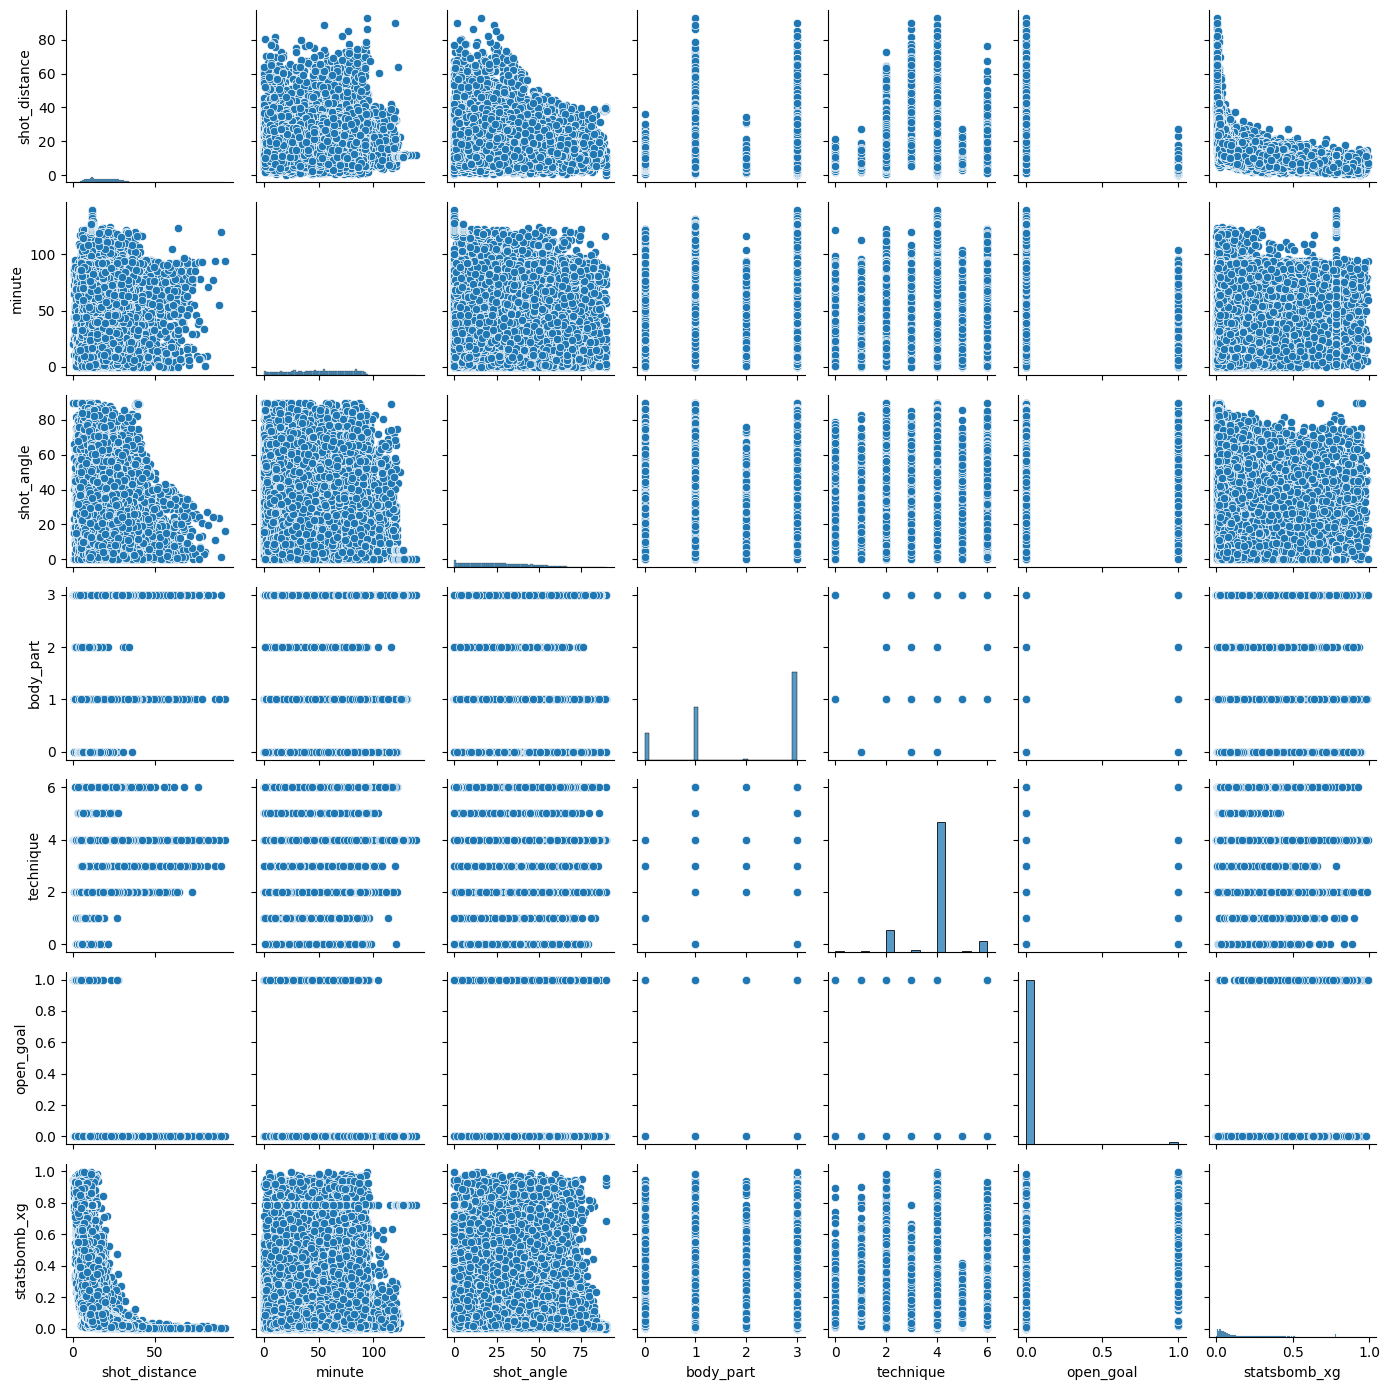

In [30]:
cols=['shot_distance','minute',
        'shot_angle', 'body_part',
        'technique', 'open_goal','statsbomb_xg',]
sns.pairplot(df[cols], size=2)
plt.tight_layout()
plt.show()


C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


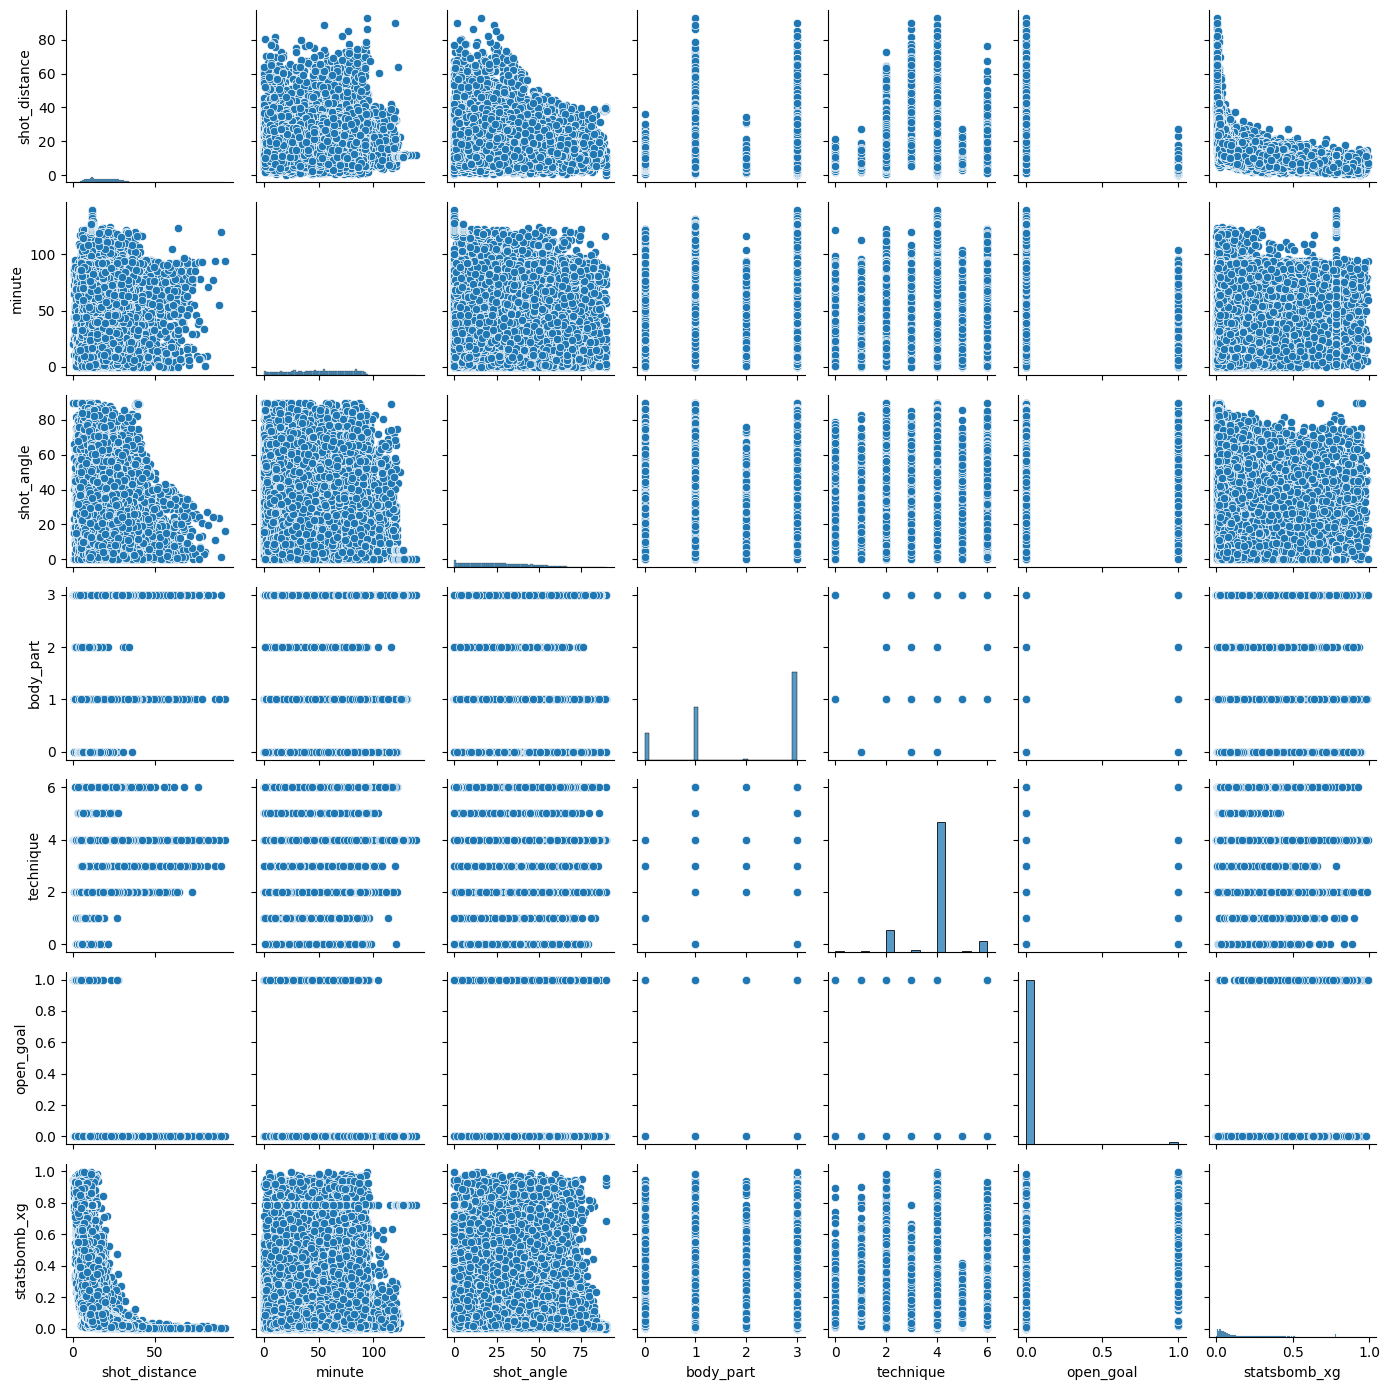

In [31]:
cols=['shot_distance','minute',
        'shot_angle', 'body_part',
        'technique', 'open_goal','statsbomb_xg',]
sns.pairplot(df2[cols], size=2)
plt.tight_layout()
plt.show()

Com podem veure la distància del xut manté una relació exponencial amb els expected goals. Concretament, la relació és de statsbomb_xg=e^(-shot_distance). Per tant provarem de fer una transformació del tipus: f(x)=-log(x) per treballar amb unes dades que s'adaptin millor a una possible regressió.

C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


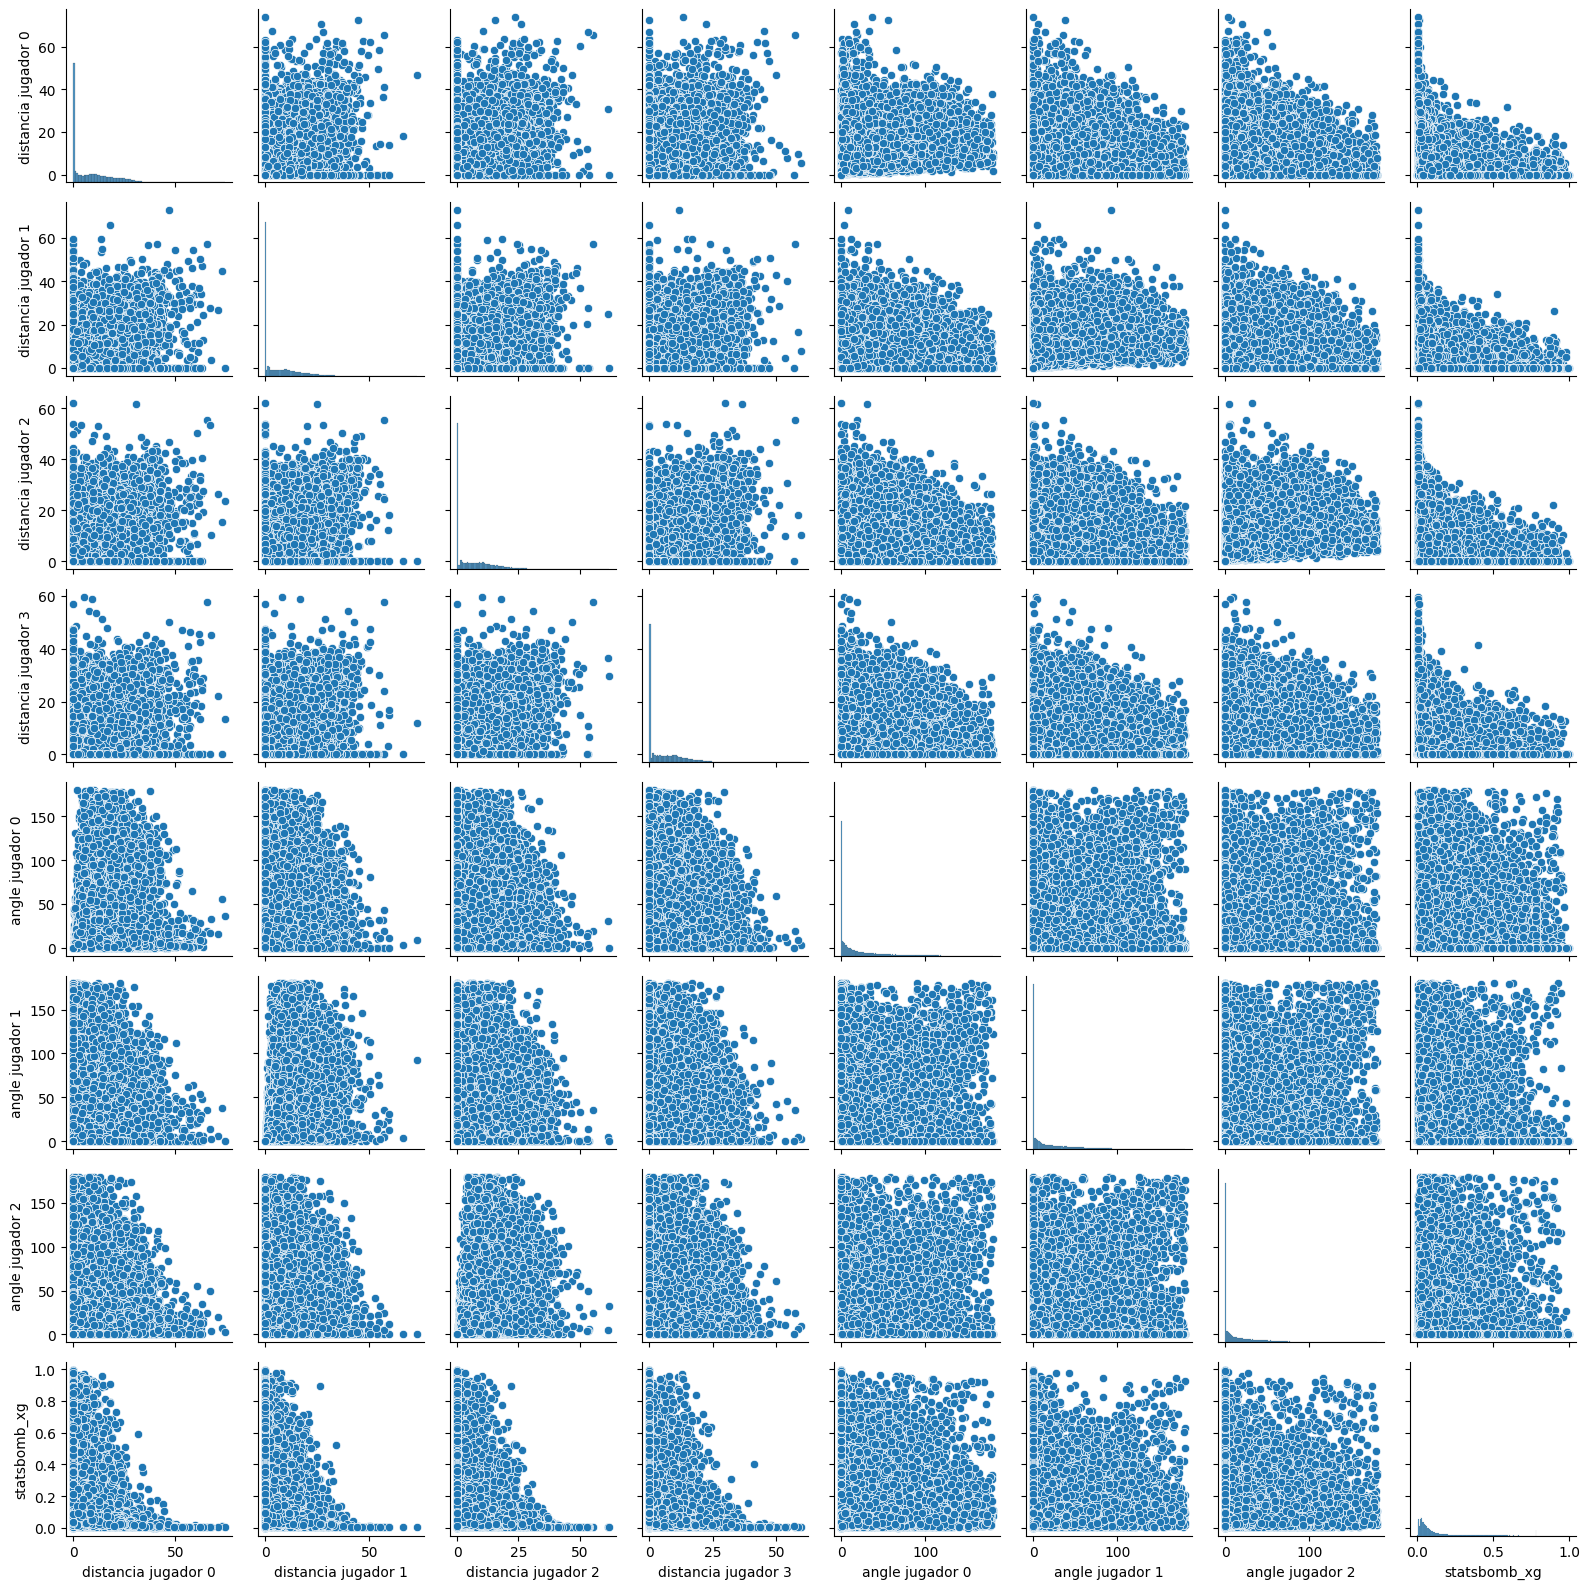

In [32]:
cols=['distancia jugador 0','distancia jugador 1',
    'distancia jugador 2', 'distancia jugador 3',
    'angle jugador 0', 'angle jugador 1','angle jugador 2','statsbomb_xg']
sns.pairplot(df[cols], size=2)
plt.tight_layout()
plt.show()

In [33]:
df['shot_distance']=-np.log(df['shot_distance'])
print(df['shot_distance'].head(10))
df['distancia jugador 0']=-np.log(df['distancia jugador 0'])
df['distancia jugador 1']=-np.log(df['distancia jugador 1'])
df['distancia jugador 2']=-np.log(df['distancia jugador 2'])
df['distancia jugador 3']=-np.log(df['distancia jugador 3'])
df['distancia jugador 4']=-np.log(df['distancia jugador 4'])
df['distancia jugador 5']=-np.log(df['distancia jugador 5'])
df['distancia jugador 6']=-np.log(df['distancia jugador 6'])
df['distancia jugador 7']=-np.log(df['distancia jugador 7'])
df['distancia jugador 8']=-np.log(df['distancia jugador 8'])

0   -2.737520
1   -2.701721
2   -3.289473
3   -2.383006
4   -2.973926
5   -2.815247
6   -2.039954
7   -3.283343
8   -2.036731
9   -3.001029
Name: shot_distance, dtype: float64


C:\Users\eloim\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
df2['shot_distance']=-np.log(df2['shot_distance'])

Correlacions de totes les variables amb expected_goals:
event_id              -0.001489
period                 0.123621
minute                 0.072110
team                  -0.021597
player                 0.008731
location              -0.157677
shot_distance          0.582967
shot_angle            -0.107237
body_part             -0.005314
play_pattern           0.064966
technique             -0.004823
statsbomb_xg           1.000000
type                   0.247115
aerial_won            -0.028143
open_goal              0.399359
distancia jugador 0    0.329312
angle jugador 0       -0.056852
distancia jugador 1    0.299041
angle jugador 1       -0.093427
distancia jugador 2    0.278063
angle jugador 2       -0.093927
distancia jugador 3    0.269498
angle jugador 3       -0.096490
distancia jugador 4    0.272859
angle jugador 4       -0.103129
distancia jugador 5    0.270787
angle jugador 5       -0.110168
distancia jugador 6    0.275452
angle jugador 6       -0.120422
distancia jugado

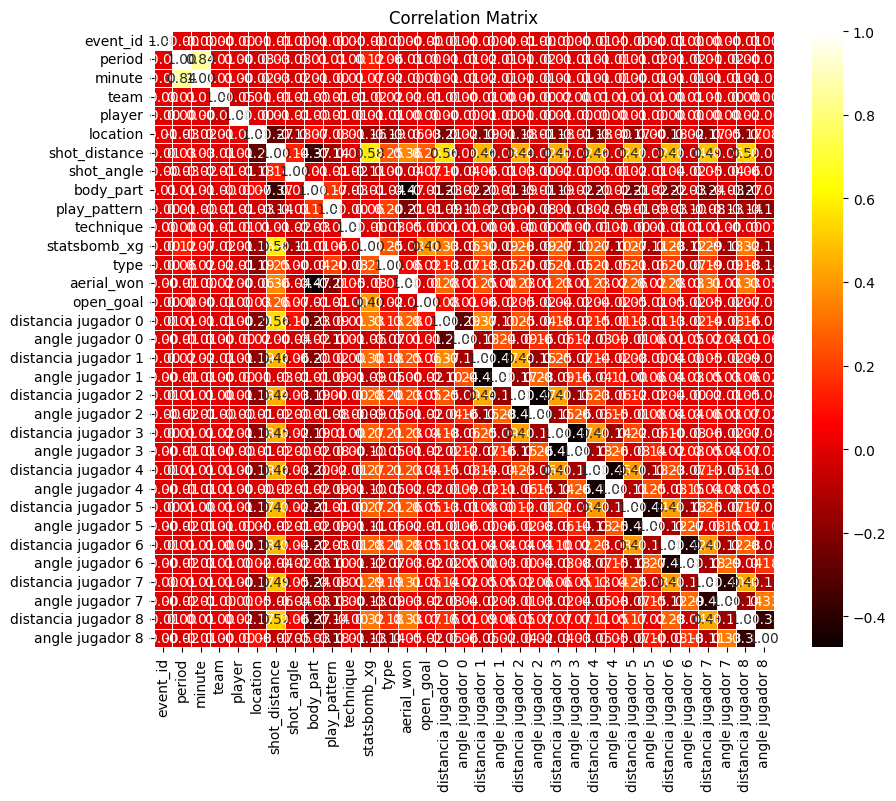

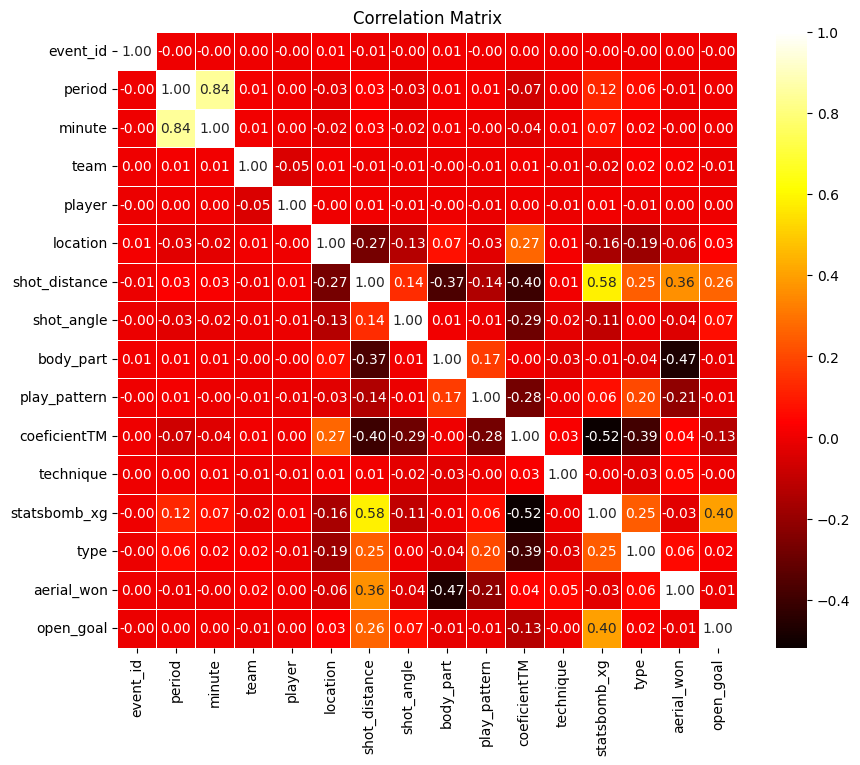

In [35]:
for i in [df,df2]:
    correlation_matrix = i.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='hot', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    correlation_with_survived = correlation_matrix['statsbomb_xg']
    print("Correlacions de totes les variables amb expected_goals:")
    print(correlation_with_survived)



In [37]:
df.drop('player', axis=1, inplace=True)
df.drop('event_id',axis=1, inplace=True)
df.drop('team', axis=1, inplace=True)
df.drop('period', axis=1, inplace=True)
df2.drop('player', axis=1, inplace=True)
df2.drop('event_id',axis=1, inplace=True)
df2.drop('team', axis=1, inplace=True)
df2.drop('period', axis=1, inplace=True)

Tot seguit normalitzarem totes aquelles característiques del model que no tinguin un significat semàntic, com per exemple open_goal o body_part (abans d'aplicar label encoder eren categòriques)

In [ ]:


df.replace([np.inf, -np.inf], 0, inplace=True)

scaler = StandardScaler()

columns_to_normalize = ['minute', 'location', 'shot_distance', 'shot_angle',
                        'distancia jugador 0', 'angle jugador 0','distancia jugador 1', 'angle jugador 1',
                        'distancia jugador 2', 'angle jugador 2','distancia jugador 3', 'angle jugador 3',
                        'distancia jugador 4', 'angle jugador 4','distancia jugador 5', 'angle jugador 5',
                        'distancia jugador 6', 'angle jugador 6','distancia jugador 7', 'angle jugador 7',
                        'distancia jugador 8', 'angle jugador 8']


df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print(df[columns_to_normalize].head())
print(df.describe())

     minute  location  shot_distance  shot_angle  distancia jugador 0  \
0 -1.730038 -0.183135       0.198990    1.539683             1.214201   
1 -1.619775  0.128278       0.269377    2.030019             1.214201   
2 -1.252229  1.129283      -0.886265   -0.864450             0.819159   
3 -1.215475 -0.503246       0.896038   -1.216901             1.214201   
4 -1.141966 -0.715490      -0.265834    1.263951             0.434230   

   angle jugador 0  distancia jugador 1  angle jugador 1  distancia jugador 2  \
0        -0.671385             1.010759        -0.651421             1.044361   
1        -0.671385             1.010759        -0.651421             1.044361   
2        -0.650963             1.010759        -0.651421             1.044361   
3        -0.671385            -0.690132        -0.020008             1.044361   
4        -0.578686            -1.166950         1.871264            -0.910419   

   angle jugador 2  ...  distancia jugador 4  angle jugador 4  \
0        

In [39]:
scaler = StandardScaler()
columns_to_normalize2 = ['minute', 'location', 'shot_distance', 'shot_angle', 'coeficientTM']
df2[columns_to_normalize2] = scaler.fit_transform(df2[columns_to_normalize2])
print(df2[['minute', 'location', 'shot_distance', 'shot_angle', 'coeficientTM']].head())

     minute  location  shot_distance  shot_angle  coeficientTM
0 -1.730038 -0.183135       0.198990    1.539683     -1.541755
1 -1.619775  0.128278       0.269377    2.030019     -1.566989
2 -1.252229  1.129283      -0.886265   -0.864450      0.374209
3 -1.215475 -0.503246       0.896038   -1.216901     -1.136810
4 -1.141966 -0.715490      -0.265834    1.263951      0.552348


Tot seguit farem un OLS regression per obtenir una espècie de diagnòstic dels dos datasets.

In [ ]:
target_att = 'statsbomb_xg'
attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes]
y = df[[target_att]]
X = sm.add_constant(X)
model=sm.OLS(y,X)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           statsbomb_xg   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     4061.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:35:08   Log-Likelihood:                 78403.
No. Observations:               87111   AIC:                        -1.567e+05
Df Residuals:                   87082   BIC:                        -1.565e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0369      0.003     12.515      0.000       0.031       0.043
minute                  0.0066      0.000     19.838      0.000       0.006       0.007
location                0.0005      0.000      1.290      0.197      -0.000       0.001
shot_distance           0.0758      0.001    116.183      0.000       0.075       0.077
shot_angle             -0.0392      0.000   -106.749      0.000      -0.040      -0.038
body_part               0.0168      0.000     51.788      0.000       0.016       0.017
play_pattern            0.0019      0.000     16.503      0.000       0.002       0.002
technique               0.0010      0.000      2.706      0.007       0.000       0.002
type                    0.0103      0.001     11.976      0.000       0.009       0.012
aerial_won             -0.1057      0.001    -73.703      0.000      -0.109      -0.103
open_goal               0.3634      0.003    105.859      0.000       0.357       0.370
distancia jugador 0     0.0106      0.000     22.407      0.000       0.010       0.012
angle jugador 0         0.0023      0.000      5.460      0.000       0.001       0.003
distancia jugador 1     0.0074      0.001     12.666      0.000       0.006       0.009
angle jugador 1         0.0006      0.001      1.209      0.227      -0.000       0.002
distancia jugador 2     0.0052      0.001      8.310      0.000       0.004       0.006
angle jugador 2        -0.0012      0.001     -2.230      0.026      -0.002      -0.000
distancia jugador 3     0.0059      0.001      9.564      0.000       0.005       0.007
angle jugador 3        -0.0005      0.001     -0.974      0.330      -0.002       0.001
distancia jugador 4     0.0063      0.001     10.375      0.000       0.005       0.008
angle jugador 4        -0.0009      0.001     -1.754      0.079      -0.002       0.000
distancia jugador 5     0.0068      0.001     11.442      0.000       0.006       0.008
angle jugador 5        -0.0015      0.000     -2.987      0.003      -0.002      -0.001
distancia jugador 6     0.0069      0.001     11.991      0.000       0.006       0.008
angle jugador 6        -0.0007      0.000     -1.472      0.141      -0.002       0.000
distancia jugador 7     0.0041      0.001      7.293      0.000       0.003       0.005
angle jugador 7        -0.0029      0.000     -5.932      0.000      -0.004      -0.002
distancia jugador 8    -0.0025      0.001     -4.595      0.000      -0.004      -0.001
angle jugador 8        -0.0049      0.000    -10.058      0.000      -0.006      -0.004
==============================================================================
Omnibus:                    44262.867   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           383731.585
Skew:                         

In [41]:
attributes = [k for k in df2.keys() if k!= target_att]
X = df2[attributes]
y = df2[[target_att]]
X = sm.add_constant(X)
model=sm.OLS(y,X)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           statsbomb_xg   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:35:08   Log-Likelihood:                 84220.
No. Observations:               87111   AIC:                        -1.684e+05
Df Residuals:                   87099   BIC:                        -1.683e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0913      0.003     33.966      0.000       0.086       0.097
minute            0.0057      0.000     18.323      0.000       0.005       0.006
location          0.0025      0.000      7.395      0.000       0.002       0.003
shot_distance     0.0766      0.000    182.518      0.000       0.076       0.077
shot_angle       -0.0457      0.000   -138.146      0.000      -0.046      -0.045
body_part         0.0144      0.000     47.648      0.000       0.014       0.015
play_pattern     -0.0009      0.000     -7.730      0.000      -0.001      -0.001
coeficientTM     -0.0560      0.000   -138.016      0.000      -0.057      -0.055
technique         0.0010      0.000      2.910      0.004       0.000       0.002
type             -0.0031      0.001     -3.999      0.000      -0.005      -0.002
aerial_won       -0.0833      0.001    -61.787      0.000      -0.086      -0.081
open_goal         0.3423      0.003    107.396      0.000       0.336       0.349
==============================================================================
Omnibus:                    37877.046   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           271499.302
Skew:                           1.950   Prob(JB):                         0.00
Kurtosis:                      10.720   Cond. No.                         75.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La nota [1] simplement ens indica que els errors estàndard dels coeficients es calculen assumint que la matriu de covariància dels errors és correcta. Això vol dir que estem assumint que els residus (les diferències entre els valors observats i els predits) són independents i tenen la mateixa variància. Si això no fos cert, els errors estàndard podrien no ser fiables, però això no ens preocupa ara mateix.

A més, com no apareix cap avís sobre multicolinealitat, podem concloure que les variables independents no estan massa correlacionades entre elles. Això vol dir que el conjunt de dades està ben preparat per fer la regressió, i no tenim problemes greus de colinealitat que puguin afectar els resultats. En resum, el models semblen estar bé per seguir endavant.

In [ ]:
###ENTRENAMENT MODEL#####
#Separem X i Y

for i in [df,df2]:

    target_att = 'statsbomb_xg'
    attributes = [k for k in i.keys() if k!= target_att]
    lr = LinearRegression(fit_intercept = True)

    X = i[attributes]
    y = i[[target_att]]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

    lr.fit(X_train,y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    r2_train = r2_score(y_train,y_pred_train)
    r2_test = r2_score(y_test,y_pred_test)

    print (r2_train,r2_test)

    mse_train_linear = mean_squared_error(y_train, y_pred_train)
    mse_test_linear = mean_squared_error(y_test, y_pred_test)

    print(f"MSE Train (Linear Regression): {mse_train_linear}")
    print(f"MSE Test (Linear Regression): {mse_test_linear}")

0.5658795125117286 0.5672048539782185
MSE Train (Linear Regression): 0.009693160115151991
MSE Test (Linear Regression): 0.009643903400713959
0.6197874729127759 0.6222297629493243
MSE Train (Linear Regression): 0.008489488538461567
MSE Test (Linear Regression): 0.008417792360356504


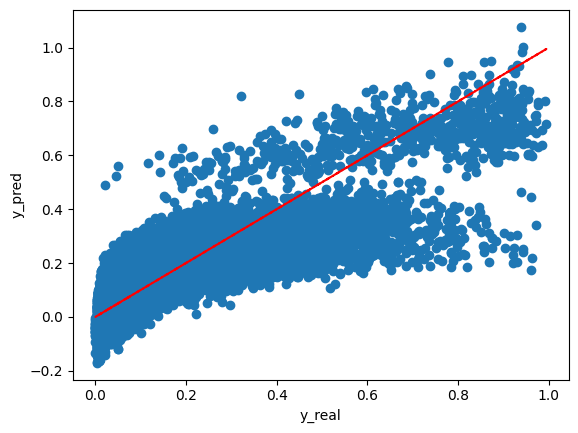

In [43]:
plt.scatter(y_train,y_pred_train)
plt.plot(y,y,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

Com podem veure, tot i ser uns resultats decents per ser el primer model que apliquem al conjunt de dades, podem veure que possiblement una regressió lineal no captura bé les relacions més complexes que podem tenir al nostre model. També podem veure que el valor del MSE és molt baix, tot i així no és tan significatiu com sembla perquè estem predint probabilitats i per tant valors entre 0 i 1, per tant és obvi que serà baix.

In [ ]:

for i in [df,df2]:
    
    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]

    X_train, X_test, y_train_polynomial, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

    poly = PolynomialFeatures(degree=2)  
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    lr = LinearRegression(fit_intercept=True)
    model=lr.fit(X_train_poly, y_train)

    y_pred_train_polynomial = lr.predict(X_train_poly)
    y_pred_test = lr.predict(X_test_poly)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
    mse_train_linear = mean_squared_error(y_train, y_pred_train)
    mse_test_linear = mean_squared_error(y_test, y_pred_test)

    print(f"MSE Train: {mse_train_linear}")
    print(f"MSE Test: {mse_test_linear}")

R2 Train: 0.6197874729127759, R2 Test: 0.8368012673216783
MSE Train: 0.008489488538461567
MSE Test: 0.003636530648588804
R2 Train: 0.6197874729127759, R2 Test: 0.8491590320707844
MSE Train: 0.008489488538461567
MSE Test: 0.003361164599351437


Els resultats indiquen que el model de regressió polinòmica de grau 2 està funcionant bé. Els valors de R² són elevats tant en entrenament com en prova, mostrant que el model és capaç de capturar la major part de la variabilitat en les dades. A més, el MSE baix en ambdós conjunts suggereix que el model fa prediccions precises tant per les dades d'entrenament com per les de prova.

Aquestes mètriques indiquen que el model té una bona capacitat de predicció i generalització, i que la transformació polinòmica de grau 2 ha estat una bona elecció per ajustar la relació entre les característiques i la variable objectiu (probabilitat de gol).

Com podem veure és molt millor que la regressió lineal perquè té un millor r2 score i MSE, a més tot i que sembla que la diferència entre train i test és més gran no és prou significativa com per considerar l'existència d'overfitting.

In [45]:
print(max(abs(lr.coef_[0])),lr.intercept_)

for i in range(len(attributes)):
  print (attributes[i],lr.coef_[0][i])



2.4152436565619775 [0.3540599]
minute -5.331330525528502e-16
location 0.0005397806579297326
shot_distance -0.010836716261993654
shot_angle 0.16206235092681115
body_part -0.028782843236791603
play_pattern 0.127852674176193
coeficientTM 1.0822872464608644
technique -0.08324854013603407
type 0.003990095422861962
aerial_won -2.4152436565619775
open_goal 0.010853254877509282


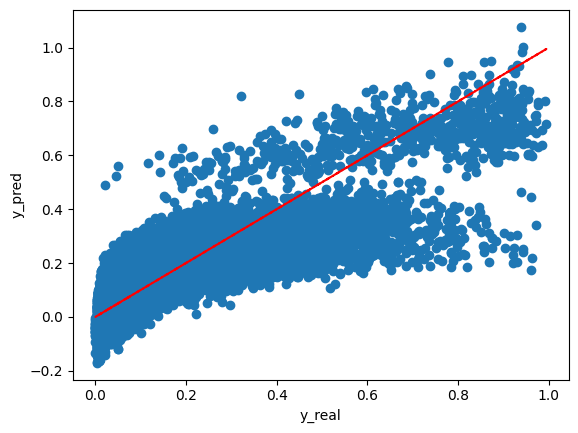

In [46]:
plt.scatter(y_train,y_pred_train)
plt.plot(y,y,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

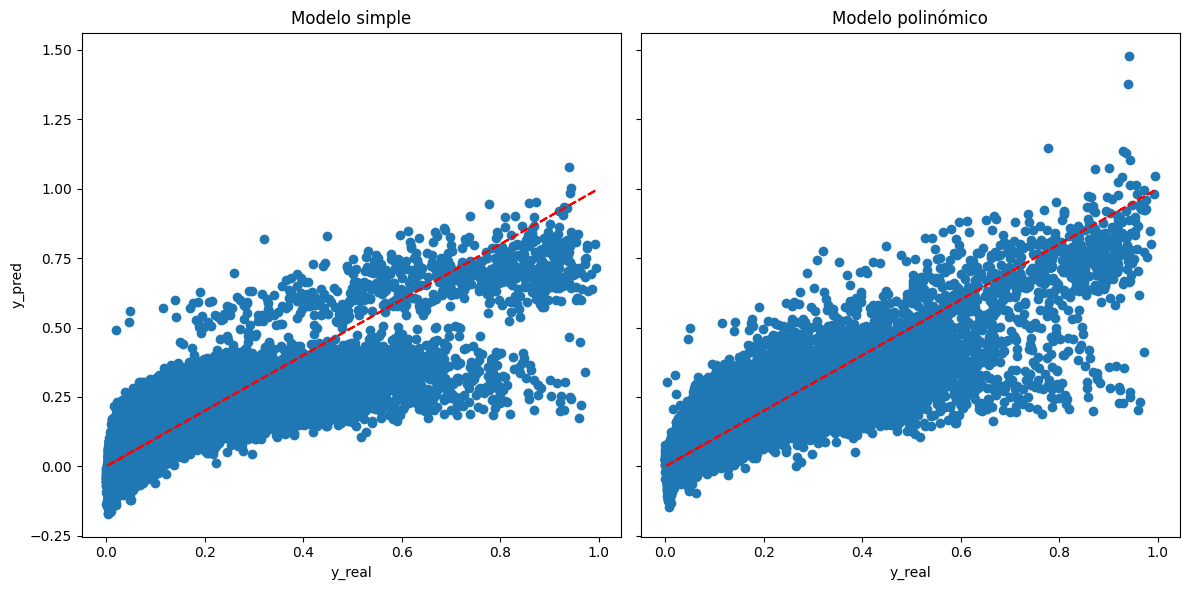

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(y_train, y_pred_train)
axes[0].plot(y, y, '--', c='red')
axes[0].set_xlabel('y_real')
axes[0].set_ylabel('y_pred')
axes[0].set_title('Modelo simple')

axes[1].scatter(y_train_polynomial, y_pred_train_polynomial)
axes[1].plot(y, y, '--', c='red')
axes[1].set_xlabel('y_real')
axes[1].set_title('Modelo polinómico')

plt.tight_layout()
plt.show()

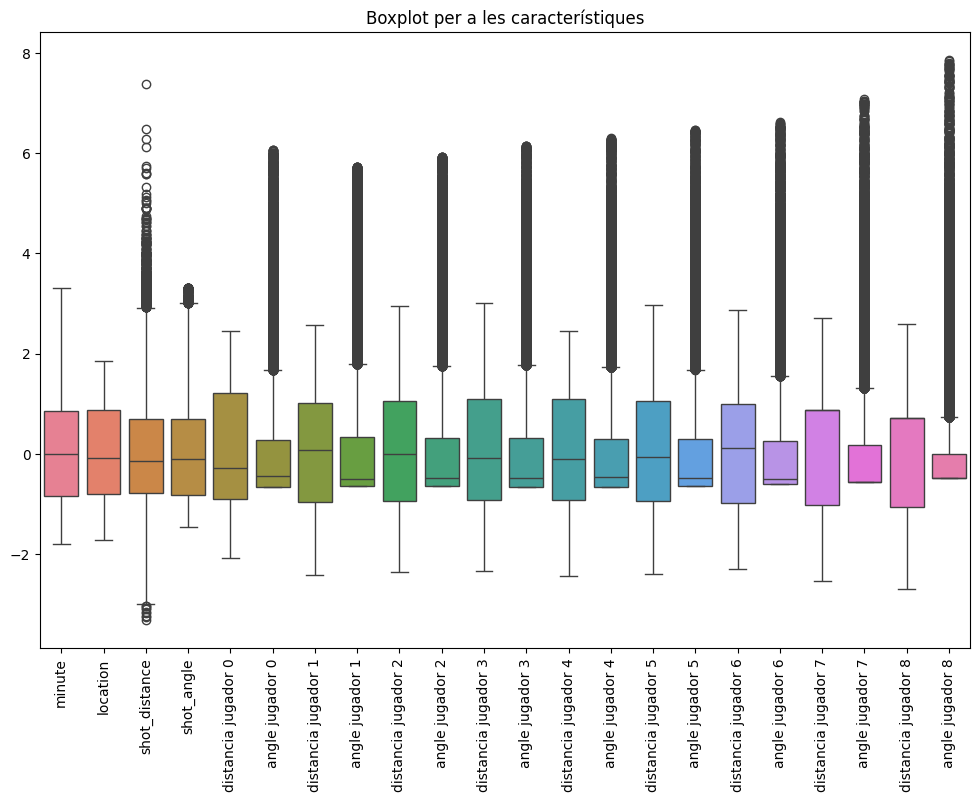

In [ ]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[columns_to_normalize])
plt.title('Boxplot per a les característiques')
plt.xticks(rotation=90)
plt.show()


Com podem veure en aquest Boxplot tenim una quantitat considerable d'outliers als angles dels rivals. Els outliers es mostren com a punts situats fora de les "caixes" (els límits de la caixa són el quartil 1 i quartil 3, i les línies de la caixa mostren el rang interquartil).

Tot seguit aplicarem IQR (Rang interquartil): El mètode IQR detecta outliers com aquells punts que es troben fora del rang definit pels quartils 1 i 3 (Q1 - 1.5IQR, Q3 + 1.5IQR).

In [49]:
Q1 = df[columns_to_normalize].quantile(0.25)
Q3 = df[columns_to_normalize].quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers utilitzant IQR
outliers = ((df[columns_to_normalize] < (Q1 - 1.5 * IQR)) | (df[columns_to_normalize] > (Q3 + 1.5 * IQR)))
print(f'Número d\'outliers per columna:\n{outliers.sum()}')


Número d'outliers per columna:
minute                     0
location                   0
shot_distance            534
shot_angle               132
distancia jugador 0        0
angle jugador 0         6748
distancia jugador 1        0
angle jugador 1         6155
distancia jugador 2        0
angle jugador 2         6270
distancia jugador 3        0
angle jugador 3         6150
distancia jugador 4        0
angle jugador 4         6281
distancia jugador 5        0
angle jugador 5         6471
distancia jugador 6        0
angle jugador 6         7312
distancia jugador 7        0
angle jugador 7         9246
distancia jugador 8        0
angle jugador 8        13287
dtype: int64


In [ ]:

for i in [df, df2]:


    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)


    ransac = RANSACRegressor(max_trials=100, min_samples=200, 
                             loss='squared_error', residual_threshold=0.2, random_state=42)
    ransac.fit(X_train_poly, y_train)

    y_pred_train = ransac.predict(X_train_poly)
    y_pred_test = ransac.predict(X_test_poly)


    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
    mse_train_ransac = mean_squared_error(y_train, y_pred_train)
    mse_test_ransac = mean_squared_error(y_test, y_pred_test)
    print(f"MSE Train (RANSAC): {mse_train_ransac}")
    print(f"MSE Test (RANSAC): {mse_test_ransac}")


R2 Train: 0.8290679702563544, R2 Test: 0.8344830367127885
MSE Train (RANSAC): 0.0038166167708402476
MSE Test (RANSAC): 0.0036881874018084575
R2 Train: 0.8407249368501329, R2 Test: 0.848164563315377
MSE Train (RANSAC): 0.003556336855685295
MSE Test (RANSAC): 0.003383324183857714


In [ ]:

for i in [df, df2]:

    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]


    threshold = 0.50 
    y_binary = (i['statsbomb_xg'] > threshold).astype(int)  # Considera gol si P(Y=1) > 0.5

    X = i[attributes]  
    y = y_binary  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    logreg = LogisticRegression(max_iter=100000)
    
    logreg.fit(X_train, y_train)

    y_prob_train = logreg.predict_proba(X_train)[:, 1]  
    y_prob_test = logreg.predict_proba(X_test)[:, 1]   

    r2_train = r2_score(y_train, y_prob_train)
    r2_test = r2_score(y_test, y_prob_test)

    print(f'R² Train: {r2_train}')
    print(f'R² Test: {r2_test}')


R² Train: 0.6747205688943335
R² Test: 0.6803540875228811
R² Train: 0.6868667756888917
R² Test: 0.7025090579750007


### **Cerca d'Hiperparàmetres amb GridSearchCV**

Realitzarem la cerca de hiperparàmetres amb **`GridSearchCV`** per als models següents: **`DecisionTreeRegressor`**, **`RandomForestRegressor`** i **`XGBRegressor`**.

Per millorar la velocitat:
- Utilitzarem una **submostra aleatòria del 20%** del conjunt de dades.
- Paral·lelitzarem la cerca amb **`n_jobs=-1`** per aprofitar tots els nuclis de la CPU.

Els **hiperparàmetres** seleccionats per cada model estan orientats a controlar la complexitat del model i millorar el rendiment. Utilitzarem (`cv=millor k per cada model`) per equilibrar la qualitat de la cerca amb el temps de càlcul.


Millor k per al model RandomForest al dataset 1: 7 amb un r2-Score de 0.8349
Millor k per al model DecisionTree al dataset 1: 20 amb un r2-Score de 0.6851
Millor k per al model XGBoost al dataset 1: 7 amb un r2-Score de 0.8530
Millor k per al model RandomForest al dataset 2: 5 amb un r2-Score de 0.8502
Millor k per al model DecisionTree al dataset 2: 5 amb un r2-Score de 0.7198
Millor k per al model XGBoost al dataset 2: 10 amb un r2-Score de 0.8536


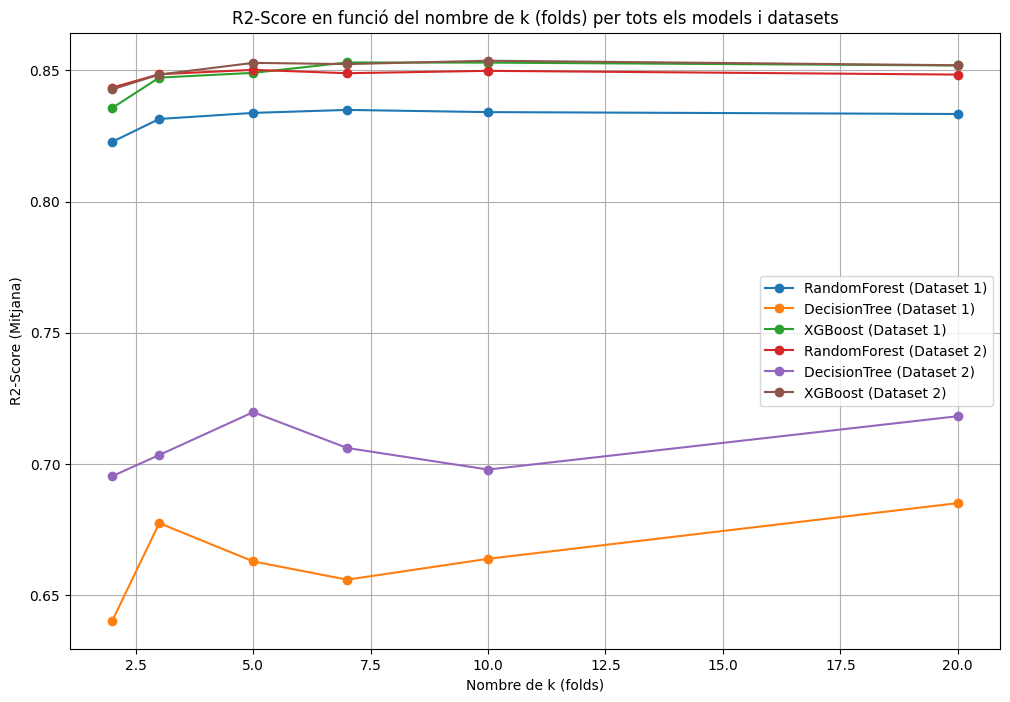

In [ ]:
millor_k = {}
all_results = {}

for idx, i in enumerate([df, df2]):

    attributes = [j for j in i.keys() if j != target_att]
    X = i[attributes]
    y = i[[target_att]]

    X_sub = X.sample(frac=0.1, random_state=42)
    y_sub = y.loc[X_sub.index]  

    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),  
    }

    k_values = [2, 3, 5, 7, 10, 20]
    r2 = make_scorer(r2_score)

    dataset_results = {}

    for nom, model in models.items():
        r2_scores = []

        for k in k_values:
            scores = cross_val_score(model, X_sub, y_sub, cv=k, scoring=r2, n_jobs=-1)
            r2_scores.append(np.mean(scores))

        millor_k[nom + str(idx)] = k_values[np.argmax(r2_scores)]
        best_score = max(r2_scores)

        dataset_results[nom] = {
            "k_values": k_values,
            "r2_scores": r2_scores,
            "best_k": k_values[np.argmax(r2_scores)],
            "best_score": best_score
        }

        print(f'Millor k per al model {nom} al dataset {idx + 1}: {k_values[np.argmax(r2_scores)]} amb un r2-Score de {best_score:.4f}')

    all_results[f"Dataset {idx + 1}"] = dataset_results

plt.figure(figsize=(12, 8))
for dataset_name, results in all_results.items():
    for model_name, model_data in results.items():
        plt.plot(model_data["k_values"], model_data["r2_scores"], marker='o', linestyle='-', label=f'{model_name} ({dataset_name})')

plt.xlabel('Nombre de k (folds)')
plt.ylabel('R2-Score (Mitjana)')
plt.title('R2-Score en funció del nombre de k (folds) per tots els models i datasets')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
print(all_results)

{'Dataset 1': {'RandomForest': {'k_values': [2, 3, 5, 7, 10, 20], 'r2_scores': [0.822763616874295, 0.8314646667376414, 0.8337782312311575, 0.8349107668118636, 0.8340779624727063, 0.8333546614797591], 'best_k': 7, 'best_score': 0.8349107668118636}, 'DecisionTree': {'k_values': [2, 3, 5, 7, 10, 20], 'r2_scores': [0.640328711124735, 0.6775073332011994, 0.6629244835343673, 0.6559650417229009, 0.6639165666757623, 0.6851222001755322], 'best_k': 20, 'best_score': 0.6851222001755322}, 'XGBoost': {'k_values': [2, 3, 5, 7, 10, 20], 'r2_scores': [0.8356788486451148, 0.847225340383992, 0.8490267645489485, 0.8529859909071292, 0.852928482196015, 0.8518295212363828], 'best_k': 7, 'best_score': 0.8529859909071292}}, 'Dataset 2': {'RandomForest': {'k_values': [2, 3, 5, 7, 10, 20], 'r2_scores': [0.8433919702017552, 0.8485112364364307, 0.8501732480421371, 0.8488905341542091, 0.8497962150269915, 0.8483668614685504], 'best_k': 5, 'best_score': 0.8501732480421371}, 'DecisionTree': {'k_values': [2, 3, 5, 7, 

Processant model: DecisionTree
Millor R² per a DecisionTree: 0.7948
temps de búsqueda: 46.49 segons

Processant model: RandomForest
Millor R² per a RandomForest: 0.8579
temps de búsqueda: 2181.65 segons

Processant model: XGBoost
Millor R² per a XGBoost: 0.8847
temps de búsqueda: 83.12 segons

Processant model: DecisionTree
Millor R² per a DecisionTree: 0.8258
temps de búsqueda: 3.46 segons

Processant model: RandomForest
Millor R² per a RandomForest: 0.8647
temps de búsqueda: 477.26 segons

Processant model: XGBoost
Millor R² per a XGBoost: 0.8780
temps de búsqueda: 46.02 segons



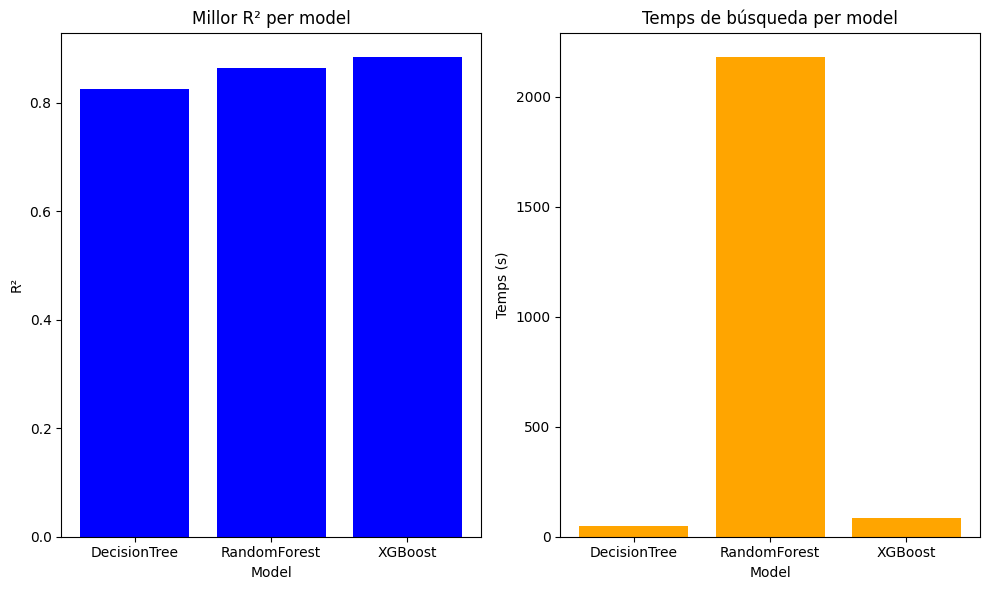

In [ ]:

results = []
for idx, i in enumerate([df, df2]):

    attributes=[j for j in i.keys() if j!=target_att]
    X=i[attributes]
    y=i[[target_att]]

    X_sub = X.sample(frac=0.2, random_state=42)
    y_sub = y.loc[X_sub.index]  

    model_dict = {"DecisionTree": {"model": DecisionTreeRegressor(random_state=42),
                "param_grid": {
                "max_depth": [None, 5, 10, 20],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 5] }},

    "RandomForest": {"model": RandomForestRegressor(random_state=42),
                "param_grid": {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2] }},

    "XGBoost": {"model": XGBRegressor(objective="reg:squarederror", random_state=42),
                "param_grid": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1],
                "max_depth": [3, 6, 9],
                "subsample": [0.8, 1.0]}}}
    """
    "AdaBoost": {
            "model": AdaBoostRegressor(random_state=42),
            "param_grid": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 1.0]}}}
    
"""
    for model_name, model_info in model_dict.items():
        print(f"Processant model: {model_name}")
        model = model_info["model"]
        param_grid = model_info["param_grid"]

        start_time = time.time()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="r2",
                                   cv=all_results[f"Dataset {idx + 1}"][model_name]["best_k"],verbose=0, n_jobs=-1)
        grid_search.fit(X_sub, y_sub.values.ravel())
        total_time = time.time() - start_time
        best_r2 = grid_search.best_score_
        results.append({
            "dataset": str(i),
            "model": model_name,
            "best_params": grid_search.best_params_,
            "best_r2": best_r2,
            "time": total_time
        })
        print(f"Millor R² per a {model_name}: {best_r2:.4f}")
        print(f"temps de búsqueda: {total_time:.2f} segons\n")

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(results_df['model'], results_df['best_r2'], color='blue')
plt.title('Millor R² per model')
plt.ylabel('R²')
plt.xlabel('Model')

plt.subplot(1, 2, 2)
plt.bar(results_df['model'], results_df['time'], color='orange')
plt.title('Temps de búsqueda per model')
plt.ylabel('Temps (s)')
plt.xlabel('Model')

plt.tight_layout()
plt.show()

In [58]:
print(results_df['best_params'])

0    {'max_depth': 10, 'min_samples_leaf': 5, 'min_...
1    {'max_depth': None, 'min_samples_leaf': 2, 'mi...
2    {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...
3    {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
4    {'max_depth': 20, 'min_samples_leaf': 2, 'min_...
5    {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...
Name: best_params, dtype: object


In [ ]:
attributes=[j for j in df.keys() if j!=target_att]

for i in[df,df2]:
    attributes=[j for j in i.keys() if j!=target_att]
    X=i[attributes]
    y=i[[target_att]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

    xg_boost = xgb.XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8, random_state=42)

    xg_boost.fit(X_train, y_train)

    y_pred_train = xg_boost.predict(X_train)
    y_pred_test = xg_boost.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print(f'R² Train: {r2_train}')
    print(f'R² Test: {r2_test}')
    print(f'MSE Train: {mse_train}')
    print(f'MSE Test: {mse_test}')

R² Train: 0.9221212818239898
R² Test: 0.8942284379214893
MSE Train: 0.0017388971647260948
MSE Test: 0.0023568904055509916
R² Train: 0.9133311985801338
R² Test: 0.8847718478315914
MSE Train: 0.0019351645300402286
MSE Test: 0.0025676100547092915


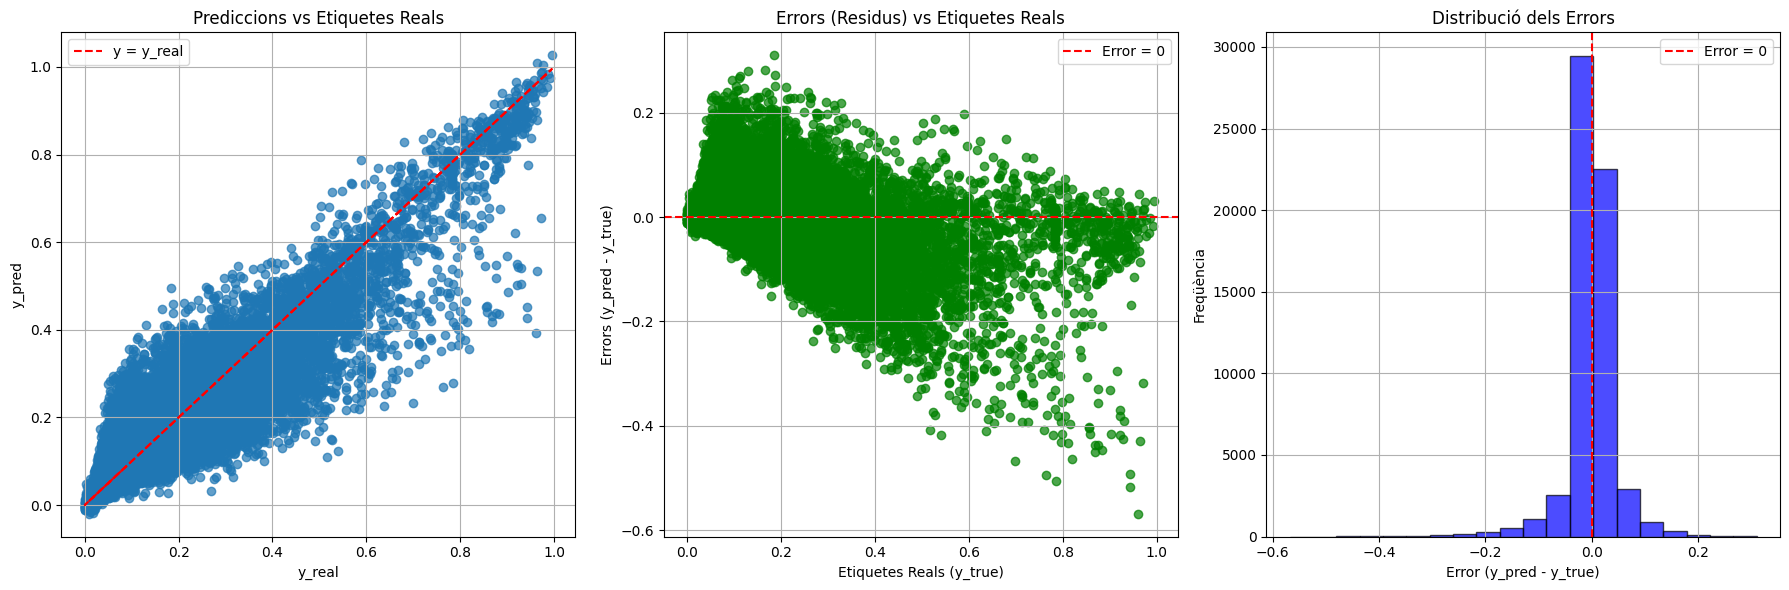

In [ ]:

# Calcular els errors
errors = y_pred_train - y_train.values.flatten()

# Crear la figura i els subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primer gràfic: Prediccions vs Etiquetes Reals
axes[0].scatter(y_train, y_pred_train, alpha=0.7)
axes[0].plot(y, y, '--', c='red', label='y = y_real')
axes[0].set_xlabel('y_real')
axes[0].set_ylabel('y_pred')
axes[0].set_title('Prediccions vs Etiquetes Reals')
axes[0].legend()
axes[0].grid(True)

# Segon gràfic: Distribució dels Errors (Residus)
axes[1].scatter(y_train, errors, color='green', alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--', label='Error = 0')
axes[1].set_title("Errors (Residus) vs Etiquetes Reals")
axes[1].set_xlabel("Etiquetes Reals (y_true)")
axes[1].set_ylabel("Errors (y_pred - y_true)")
axes[1].legend()
axes[1].grid(True)

# Tercer gràfic: Histograma dels Errors
axes[2].hist(errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='red', linestyle='--', label='Error = 0')
axes[2].set_title("Distribució dels Errors")
axes[2].set_xlabel("Error (y_pred - y_true)")
axes[2].set_ylabel("Freqüència")
axes[2].legend()
axes[2].grid(True)

# Ajustar l'espai entre els gràfics
plt.tight_layout()
plt.show()

# **Reconeixement d'imatges**


In [ ]:
model = YOLO('yolov8s.pt') 


model.train(
    data="C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/data.yaml",
    epochs=40,         
    imgsz=640,         
    batch=8,          
    name='goal_detection'  
)

model.val(data='data.yaml', test=True)

In [ ]:
model = YOLO('runs/detect/goal_detection2/weights/best.pt') 

results = model('C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/test_reduced/images/0006_6_jpg.rf.b37378d2e4eba34f23425728c92ed5c4.jpg')


for detection in results[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objeto en coordenadas ({x1}, {y1}) a ({x2}, {y2})")
annotated_image = results[0].plot()

plt.imshow(annotated_image)
plt.show()

llista=results[0].boxes
llista2=results[0]
print(llista,llista2)

results= pd.read_csv('C:/Users/eloim/runs/detect/goal_detection2/results.csv')
print(results['metrics/precision(B)'])

In [ ]:

path='C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/goal_detection2/confusion_matrix.png'
img = mpimg.imread(path)

plt.imshow(img)
plt.axis('off')  
plt.show()

## Avaluació del Model: Matriu de Confusió i Anàlisi de Resultats

Com podem veure a la **matriu de confusió**, el nostre model prediu molt bé les **porteries**. Les prediccions per aquesta classe són molt precises, amb pocs errors. Això indica que el model ha aprés de manera efectiva a identificar les porteries en les imatges.

No obstant això, també podem observar que el model comet un nombre significatiu de **falsos positius** en la classe de **persones**. En altres paraules, el model tendeix a catalogar com a "persona" allò que realment és **fons** o altres elements del camp. Aquest comportament pot ser un problema, ja que pot generar deteccions inexactes, especialment en imatges amb un fons complex o amb molts elements en escena.

### Solució Proposada: Prioritzar la Mètrica de *Precision*

Per abordar aquest problema, decidim centrar-nos en la mètrica de **precision**. La *precision* mesura la qualitat de les prediccions positives del model, és a dir, quantes de les instàncies que el model ha etiquetat com a "persona" realment són persones. Aquesta mètrica ens ajudarà a evitar considerar com a "persona" aquells elements que no ho són realment (com el fons o altres objectes).

La fórmula per calcular la *precision* és:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

On:
- **True Positives (TP)** són les prediccions correctes, és a dir, les persones que el model ha detectat com a persones i eren persones reals.
- **False Positives (FP)** són les deteccions errònies, és a dir, les instàncies que el model ha etiquetat com a "persona", però realment no ho eren (en aquest cas, fons o altres objectes).

### Conclusió

Per evitar que el model consideri com a persones objectes que no ho són (fons, altres elements), ens basarem en la mètrica de **precision** per ajustar el model i millorar els resultats. Això ens permetrà controlar millor la detecció de persones i reduir el nombre de falsos positius.

En resum, mentre que les deteccions de les porterias són molt bones, hem de ser més estrictes en les prediccions de les persones i aplicar la mètrica de precision per garantir que només considerem aquells elements que realment són persones.


In [ ]:
import matplotlib.image as mpimg

path='C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/goal_detection2/F1_curve.png'
img = mpimg.imread(path)

plt.imshow(img)
plt.axis('off')  
plt.show()

In [ ]:
model = YOLO('runs/detect/goal_detection2/weights/best.pt') 
model2= YOLO('yolov8s.pt') 

results= model('C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/train/images/0189_jpg.rf.0896dfb92beb7de71f95cc3439ea264a.jpg')
results2= model2('C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/soccer detection dataset/train/images/0189_jpg.rf.0896dfb92beb7de71f95cc3439ea264a.jpg')

for detection in results[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objecte en coordenades ({x1}, {y1}) a ({x2}, {y2})")
annotated_image = results[0].plot()

plt.imshow(annotated_image)
plt.show()

for detection in results2[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objecte en coordenades ({x1}, {y1}) a ({x2}, {y2})")
annotated_image2 = results2[0].plot()

plt.imshow(annotated_image2)
plt.show()

llista=results[0].boxes
llista2=results[0]
print(llista,llista2)

results= pd.read_csv('C:/Users/eloim/runs/detect/goal_detection2/results.csv')
print(results['metrics/precision(B)'])

Com podem veure, el nostre model entrenat etiqueta prácticament a la perfecció (afegeix persones) aquesta imatge extreta del conjunt test.

In [ ]:
model = YOLO('runs/detect/goal_detection2/weights/best.pt') 
model2= YOLO('yolov8s.pt') 

results= model('C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shoots_img/2.jpg')
results2 = model2('C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shoots_img/2.jpg')
for detection in results[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objecte en coordenades ({x1}, {y1}) a ({x2}, {y2})")
annotated_image = results[0].plot()

plt.imshow(annotated_image)
plt.show()

for detection in results2[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objecte en coordenades ({x1}, {y1}) a ({x2}, {y2})")
annotated_image2 = results2[0].plot()

plt.imshow(annotated_image2)
plt.show()

llista=results[0].boxes
llista2=results[0]
print(llista,llista2)

results= pd.read_csv('C:/Users/eloim/runs/detect/goal_detection2/results.csv')
print(results['metrics/precision(B)'])

En canvi, aquesta imatge que no està present al nostre dataset no l'etiqueta. Probablement aquest problema es degui a que es una imatge extreta d'un partit professional que és molt diferent que les que hem fet servir per entrenar el model. Per altra banda el model per deefcte YOLOV8 en la versió small detecta simplement les persones. 

In [ ]:
model = YOLO('yolov8n.pt') 


model.train(
    data="C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/Cas-kaggle-/goal post/data.yaml",
    epochs=30,         
    imgsz=640,         
    batch=16,          
    name='porteria'  
)

model.val(data='data.yaml', test=True)



In [ ]:
model = YOLO('runs/detect/porteria/weights/best.pt') 

results= model("C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shoots_img/2.jpg")

for detection in results[0].boxes:
    x1, y1, x2, y2 = detection.xyxy[0]
    print(f"Objecte en coordenades ({x1}, {y1}) a ({x2}, {y2})")
annotated_image = results[0].plot()

plt.imshow(annotated_image)
plt.show()